In [145]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score


## Read data

In [117]:
df = pd.read_csv('./data/AdSmartABdata.csv', parse_dates=['date'])

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   auction_id   8077 non-null   object        
 1   experiment   8077 non-null   object        
 2   date         8077 non-null   datetime64[ns]
 3   hour         8077 non-null   int64         
 4   device_make  8077 non-null   object        
 5   platform_os  8077 non-null   int64         
 6   browser      8077 non-null   object        
 7   yes          8077 non-null   int64         
 8   no           8077 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 568.0+ KB


In [119]:
df.describe()

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   auction_id   8077 non-null   object        
 1   experiment   8077 non-null   object        
 2   date         8077 non-null   datetime64[ns]
 3   hour         8077 non-null   int64         
 4   device_make  8077 non-null   object        
 5   platform_os  8077 non-null   int64         
 6   browser      8077 non-null   object        
 7   yes          8077 non-null   int64         
 8   no           8077 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 568.0+ KB


# Counts of categorical Variables

## Experiment value counts

In [121]:
df['experiment'].value_counts()

control    4071
exposed    4006
Name: experiment, dtype: int64

## Experiment value visualization

<AxesSubplot:>

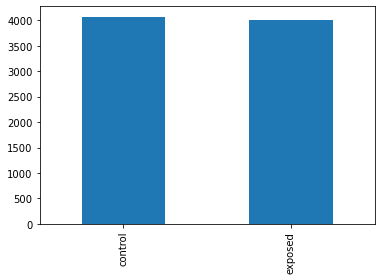

In [122]:
df['experiment'].value_counts().plot(kind='bar')

## Device make value counts

In [123]:
df['device_make'].value_counts()

Generic Smartphone    4743
iPhone                 433
Samsung SM-G960F       203
Samsung SM-G973F       154
Samsung SM-G950F       148
                      ... 
Samsung SM-N9500         1
VF-795                   1
Samsung SM-G930V         1
Samsung SM-G930L         1
Samsung SM-J701F         1
Name: device_make, Length: 270, dtype: int64

## Browser value counts

In [124]:
df['browser'].value_counts()

Chrome Mobile                 4554
Chrome Mobile WebView         1489
Samsung Internet               824
Facebook                       764
Mobile Safari                  337
Chrome Mobile iOS               51
Mobile Safari UI/WKWebView      44
Opera Mobile                     3
Pinterest                        3
Chrome                           3
Puffin                           1
Firefox Mobile                   1
Opera Mini                       1
Android                          1
Edge Mobile                      1
Name: browser, dtype: int64

<AxesSubplot:title={'center':'Browsers'}>

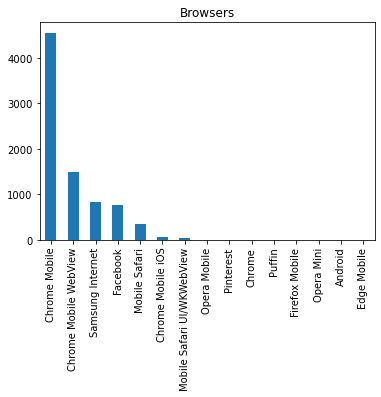

In [125]:
df['browser'].value_counts().plot(kind='bar', title='Browsers')

## Hour values plot

<AxesSubplot:title={'center':'Hour values'}, ylabel='Density'>

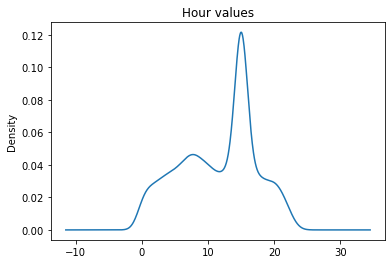

In [126]:
df['hour'].plot(kind='kde', title='Hour values')

## Yes answers plot

<AxesSubplot:title={'center':'Yes Answers'}, ylabel='Density'>

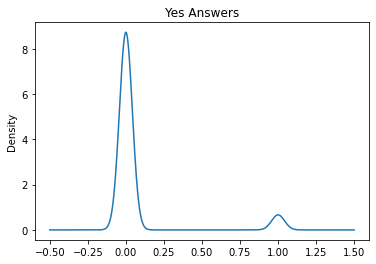

In [127]:
df['yes'].plot(kind='kde', title='Yes Answers')

## No answers plot

<AxesSubplot:title={'center':'No Answers'}, ylabel='Density'>

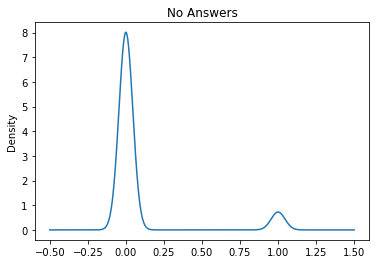

In [128]:
df['no'].plot(kind='kde', title='No Answers')

## Platform_Os values plot

<AxesSubplot:title={'center':'Platform_os'}, ylabel='Density'>

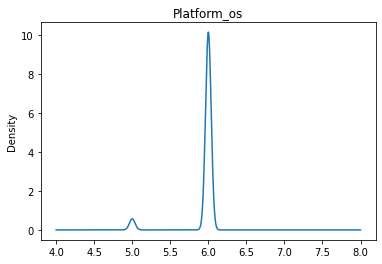

In [129]:
df['platform_os'].plot(kind='kde', title='Platform_os')

## XGBoost model

### Get index for entries with a 'yes' or 'no' answer

In [130]:
answered_index = ((df['yes'] == 1) | (df['no'] ==1))

### Clean the data

In [131]:
cleaned_df = df[answered_index].copy()
cleaned_df.reset_index(drop=True, inplace=True)          # reset the index

### Get the data for the modeling proccess

In [132]:
model_df = cleaned_df[cleaned_df.columns[:-1]].copy()    # create data to be used for modeling
model_df.rename(columns={'yes':'answer'}, inplace=True)  # rename the 'yes' column to 'answer'

### Split data by browser and platform_os

In [133]:
model_df_browser = model_df[['auction_id', 'experiment', 'date', 'hour', 'device_make', 'browser', 'answer']].copy()
model_df_platform_os = model_df[['auction_id', 'experiment', 'date', 'hour', 'device_make', 'platform_os', 'answer']].copy()

In [134]:
 train_brwsr, test_brwsr, validate_brwsr  = \
              np.split(model_df_browser[model_df_browser.columns[1:]].sample(frac=1, random_state=42), 
                       [int(.7*len(model_df_browser)), int(.9*len(model_df_browser))])

In [135]:
brwsr_X_col = model_df_browser.columns[1:-1]

brwsr_train =  train_brwsr[brwsr_X_col]
brwsr_train_labels = train_brwsr['answer']

brwsr_test =  brwsr_train[brwsr_X_col]
brwsr_test_labels = train_brwsr['answer']

brwsr_val =  train_brwsr[brwsr_X_col]
brwsr_val_labels = train_brwsr['answer']

In [136]:
numerical_browser = ['date','hour']
cat_browser = ['experiment', 'device_make', 'browser']

In [137]:
class ExtractDay(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self               # take the date column and pss to self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['date'] = X['date'].apply(lambda x:x.weekday())
        return X

In [138]:
numerical_platform_os = ['date','hour','platform_os']
cat_platform_os = ['experiment', 'device_make']

In [139]:
num_pipeline = Pipeline([
    ('day_extractor', ExtractDay()),
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numerical_browser),
    ('cat', OneHotEncoder(), numerical_browser)
])

In [141]:
brswr__train_processed = full_pipeline.fit_transform(brwsr_train)

In [144]:
xgbc = GradientBoostingClassifier()

In [ ]:
train_os, test_os, validate_so  = \
              np.split(model_df_platform_os[model_df_platform_os.columns[1:]].sample(frac=1, random_state=42), 
                       [int(.7*len(model_df_platform_os)), int(.9*len(model_df_platform_os))])